In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import urllib
import matplotlib.pyplot as plt

In [2]:
tf.reset_default_graph()

In [3]:
df_pm = pd.read_json("dati_milano/pm10_11_18.json")
df_temp = pd.read_json("dati_milano/temperature_11_18.json")
df_umi = pd.read_json("dati_milano/umidita_11_18.json")
df_prec = pd.read_json("dati_milano/precipitazioni_11_18.json")

In [4]:
df = df_pm.shift(1)
df["temp"] = df_temp
df["umi"] = df_umi
df["prec"] = df_prec
df["mese"] = df.index.month

In [5]:
df = df.dropna()

In [6]:
df.head()

,pm10,temp,umi,prec,mese
2012-01-12,88.0,4.5,77.1,0.0,1
2012-01-13,106.0,4.9,78.4,0.0,1
2012-01-14,88.0,0.2,91.6,0.2,1
2012-01-15,96.0,-2.6,95.1,0.2,1
2012-01-16,87.0,-1.6,88.7,0.0,1


In [7]:
df["pm10"] = df["pm10"].astype(int)

In [8]:
df.prec = (100 * (df.prec / df.prec.max())).astype(int)
df.temp = (100 * ((df.temp - df.temp.min())/ df.temp.max())).astype(int)
df.umi = df.umi.astype(int)
df["pm10"].loc[df["pm10"] < 20] = 1
df["pm10"].loc[(df["pm10"] >= 20) & (df["pm10"] < 35)] = 2
df["pm10"].loc[(df["pm10"] >= 35) & (df["pm10"] < 50)] = 3
df["pm10"].loc[(df["pm10"] >= 50) & (df["pm10"] < 100)] = 4
df["pm10"].loc[df["pm10"] >= 100] = 5

In [9]:
df.head()

,pm10,temp,umi,prec,mese
2012-01-12,4,34,77,0,1
2012-01-13,5,35,78,0,1
2012-01-14,4,21,91,0,1
2012-01-15,4,12,95,0,1
2012-01-16,4,15,88,0,1


In [10]:
test = df.iloc[-301:]
df = df.iloc[:-100]

In [11]:
n_steps = 250
n_inputs = 5
n_neurons = 100
n_outputs = 1

In [12]:
resolution = 1
lun = len(df) - n_steps

def time_series(t):
    array = []
    for x in t:
        array.append(df.iloc[x].values)
    return np.array(array).copy()

def next_batch(batch_size, n_steps):
    t0 = np.random.randint(lun, size = (batch_size, 1))
    Ts = t0 + np.arange(0, n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, n_inputs), ys[:, 1:, 0].reshape(-1, n_steps, 1)

In [13]:
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

cell = [tf.keras.layers.GRUCell(units = n_neurons, activation = "relu"),
        tf.keras.layers.GRUCell(units = 50, activation = "relu")
       ]
layer = tf.keras.layers.RNN(cell, dtype=tf.float32, return_state = False, return_sequences = True)(X)
outputs = tf.keras.layers.Dense(1)(layer)
outputs = tf.keras.layers.Reshape((-1, n_outputs))(outputs)

Instructions for updating:
Colocations handled automatically by placer.


In [14]:
learning_rate = 0.001

loss = tf.nn.sigmoid_cross_entropy_with_logits(logits = outputs, labels = y)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [15]:
saver = tf.train.Saver()

In [16]:
n_iterations = 600
batch_size = 100

test_X = np.array(test.iloc[-(n_steps + 1):-1].values)
test_Y = np.array(test.pm10.iloc[-(n_steps):].values)
X_test = test_X.reshape(1, -1, n_inputs)
y_test = test_Y.reshape(1, -1, 1)

mse_trainset = []
mse_testset = []

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            mse_trainset.append(mse)
            mse_testset.append(loss.eval(feed_dict={X: X_test, y: y_test}))
            print(iteration, "\tMSE:", mse, "\tMSE test", mse_testset[-1])
    
    saver.save(sess, "./modelli/classificatore")

0 	MSE: [[[ -1.6070071 ]
  [ -0.9866564 ]
  [ -6.897815  ]
  ...
  [ -5.619604  ]
  [-11.117371  ]
  [-11.314068  ]]

 [[ -1.2915514 ]
  [ -5.1584864 ]
  [ -4.9361014 ]
  ...
  [-12.433109  ]
  [-16.790462  ]
  [-18.102762  ]]

 [[ -7.333277  ]
  [-15.321156  ]
  [-15.078567  ]
  ...
  [ -4.9976196 ]
  [ -5.095897  ]
  [ -5.233311  ]]

 ...

 [[ -2.1633003 ]
  [ -0.10283607]
  [ -0.31719023]
  ...
  [-19.701962  ]
  [-20.205318  ]
  [-13.166254  ]]

 [[ -2.6970227 ]
  [ -2.5309603 ]
  [-11.626992  ]
  ...
  [-18.680466  ]
  [-18.053951  ]
  [-12.201801  ]]

 [[ -5.732065  ]
  [-11.731569  ]
  [ -5.6368785 ]
  ...
  [ -6.02696   ]
  [-11.647127  ]
  [-11.935345  ]]] 	MSE test [[[-8.04931104e-01]
  [-2.51009369e+00]
  [-8.76577187e+00]
  [-1.18799095e+01]
  [-1.48740816e+01]
  [-1.03267937e+01]
  [-1.02976885e+01]
  [-1.53496885e+01]
  [-1.57758989e+01]
  [-1.09848385e+01]
  [-8.80233192e+00]
  [-8.50179577e+00]
  [ 5.27755963e-03]
  [-6.41714907e+00]
  [-5.71688128e+00]
  [-1.00619049e+

300 	MSE: [[[nan]
  [nan]
  [nan]
  ...
  [nan]
  [nan]
  [nan]]

 [[nan]
  [nan]
  [nan]
  ...
  [nan]
  [nan]
  [nan]]

 [[nan]
  [nan]
  [nan]
  ...
  [nan]
  [nan]
  [nan]]

 ...

 [[nan]
  [nan]
  [nan]
  ...
  [nan]
  [nan]
  [nan]]

 [[nan]
  [nan]
  [nan]
  ...
  [nan]
  [nan]
  [nan]]

 [[nan]
  [nan]
  [nan]
  ...
  [nan]
  [nan]
  [nan]]] 	MSE test [[[nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan]
  [nan

In [17]:
test_X = np.array(test.iloc[-(n_steps + 1):-1].values)
test_Y = np.array(test.pm10.iloc[-(n_steps):].values)

with tf.Session() as sess:
    saver.restore(sess, "./modelli/classificatore")

    X_new = test_X.reshape(1, -1, n_inputs)
    y_pred = sess.run(outputs, feed_dict={X: X_new})

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./modelli/classificatore


ValueError: x and y can be no greater than 2-D, but have shapes (5,) and (5, 100, 250, 1)

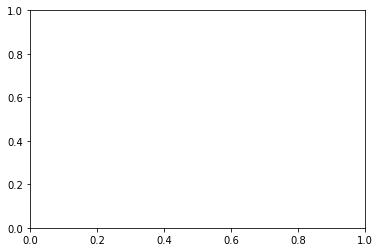

In [18]:
plt.plot(mse_trainset[1:], "r")
plt.plot(mse_testset[1:])
plt.show()

In [ ]:
plt.plot(y_pred[0], "r")
plt.plot(test_Y)
plt.show()

In [ ]:
plt.plot(y_pred[0][-30:], "r")
plt.plot(test_Y[-30:])
plt.show()